In [ ]:
# TAYKO SOFTWARE CATALOGER continued...
# b.Run logistic regression with L2 penalty, using method LogisticRegressionCV, to select the best subset of variables,
# then use this model to classify the data into purchasers and nonpurchasers. Use only the training set for running the
# model. (Logistic regression is used because it yields an estimated “probability of purchase,” which is required later in
# the analysis.)


In [6]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from math import log
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error as MSE

In [2]:
case_df=pd.read_csv('Tayko.csv')

In [3]:
case_df.columns = [c.replace(' ', '_') for c in case_df.columns]
case_df.columns = [c.replace('=', '_') for c in case_df.columns]

In [4]:
# Filtering out our data on the basis of purchasers only.
case_df=case_df[case_df['Purchase']==1]

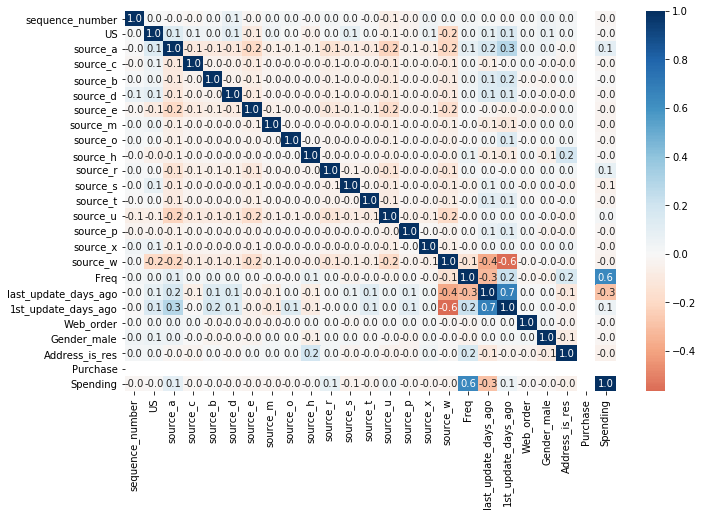

In [7]:
# Running correlation matrix, to deal with multicollinearity
corr = case_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

plt.show()

In [9]:
#Predictor and outcome variables for variable selection
# We removed Spending from the predictor list because it is target now. 
# Removed 1st_update_days_ago as well due to high correlation, and sequence_number is just an ID.
y = case_df['Spending']
X = case_df.drop(columns=['Spending','sequence_number','last_update_days_ago'])

In [10]:
# Splitting the data into 60% training and 40% testing
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [12]:
#Forward selection
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)


Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, 1st_update_days_ago, Web_order, Gender_male, Address_is_res, Purchase
Start: score=8123.51, constant
Step: score=7834.90, add Freq
Step: score=7814.54, add Address_is_res
Step: score=7802.53, add 1st_update_days_ago
Step: score=7799.38, add source_r
Step: score=7796.08, add source_a
Step: score=7792.91, add source_u
Step: score=7791.19, add source_h
Step: score=7791.19, add None


In [13]:
#Stepwise regression
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, 1st_update_days_ago, Web_order, Gender_male, Address_is_res, Purchase
Start: score=8123.51, constant
Step: score=7834.90, add Freq
Step: score=7814.54, add Address_is_res
Step: score=7802.53, add 1st_update_days_ago
Step: score=7799.38, add source_r
Step: score=7796.08, add source_a
Step: score=7792.91, add source_u
Step: score=7791.19, add source_h
Step: score=7791.19, unchanged None
['Freq', 'Address_is_res', '1st_update_days_ago', 'source_r', 'source_a', 'source_u', 'source_h']


In [14]:
# Regression Summary statistics for stepwise regression
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : 4.1171
       Root Mean Squared Error (RMSE) : 169.0312
            Mean Absolute Error (MAE) : 102.8035
          Mean Percentage Error (MPE) : -69.6319
Mean Absolute Percentage Error (MAPE) : 101.1441


In [15]:
# Fit regression model
#Regression Tree
model=DecisionTreeRegressor(max_depth=4)
model.fit(train_X,train_y)
regressionSummary(valid_y, model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 7.0116
       Root Mean Squared Error (RMSE) : 173.2521
            Mean Absolute Error (MAE) : 101.1772
          Mean Percentage Error (MPE) : -93.5017
Mean Absolute Percentage Error (MAPE) : 118.1691
